# How to specify contact models

This tutorial deepens your knowledge on contact models. Contact models were also discussed in the [first tutorial](how_to_simulate.ipynb), but crucial parts like recurrent contact models are missing.

In [1]:
%matplotlib inline

import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sid
from sid.config import INDEX_NAMES

warnings.filterwarnings(
    "ignore", message="indexing past lexsort depth may impact performance."
)

## Introduction

To reiterate from the previous tutorial, there exist two flavors of contact models.

- Recurrent contact models are used when people belong to a certain group and if they meet this group, they meet all participating members. You would use recurrent models to model school classes, households, and colleagues/work groups.

- Random contact models are used when people do not always meet the same predefined groups, but contacts happen more randomly. Usually, people are more likely to meet a person from their own group, but there is also a lower probability of meeting someone from another group. Groups can be formed by combining any number of characteristics. If we would use age groups, we would say contacts are assortative by age. Each person also has a budget for the number of people she can meet. You would use random contact models, for example, to model meetings during freetime activities, infrequent contacts at work, or acquaintances.

Here, we are going to have a closer look at each category and provide examples on how to implement them.

First, we create states with age groups and geographic information, initialise the contact models and parameters, and the initial conditions.

In [2]:
n_individuals = 10_000
available_ages = [
    "0-9",
    "10-19",
    "20-29",
    "30-39",
    "40-49",
    "50-59",
    "60-69",
    "70-79",
    "80-100",
]

ages = np.random.choice(available_ages, size=n_individuals)
regions = np.random.choice(["North", "East", "South", "West"], size=n_individuals)

initial_states = pd.DataFrame({"age_group": ages, "region": regions}).astype("category")
initial_states.head(5)

,age_group,region
0,20-29,West
1,50-59,North
2,20-29,West
3,80-100,South
4,60-69,South


In [3]:
contact_models = {}

In [4]:
params = sid.load_epidemiological_parameters()
params.head(5)

value
category           subcategory        name                     
health_system      icu_limit_relative icu_limit_relative  50.00
cd_infectious_true all                1                    0.39
                                      2                    0.35
                                      3                    0.22
                                      5                    0.04

In [5]:
initial_conditions = {"initial_infections": 100, "initial_immunity": 50}

We further have to specify the parameters governing the immunity level and waning. For a detailed explaination of these parameters see the tutorial notebook on how to model immunity.

In [6]:
immunity_params = pd.read_csv("immunity_params.csv", index_col=INDEX_NAMES)

params = pd.concat((params, immunity_params))

## Random contact models

We start with random contact models since they are more familiar from the [previous tutorial](how_to_simulate.ipynb). We will create a model called ``"random_encounters"`` and represents random daily encounters with just a few individuals. The contacts are weakly assortative with regards to age and region.

First, we focus on the contact model function. The function has to provide the following arguments.

- ``states`` which is a ``pandas.DataFrame`` with the information on all individuals.
- ``params`` which is a ``pandas.DataFrame`` with a three-dimensional index containing the parameters.
- ``seed`` is an integer which can be used to set up the random number generator and ensure reproducibility. The value is part of a seed sequence so that each seed is only used once.

The return of the function is a ``pandas.Series`` with the same index as ``states``. The values are integer or floats which represent the number of contacts each person can have. Floats are also permitted and rounded such that the sum of contacts remains the same. If the value of individuals is zero, they will not have any contacts.

In [7]:
def random_encounters(states, params, seed):
    np.random.seed(seed)
    contacts = np.random.choice(np.arange(3), size=states.shape[0])
    return pd.Series(index=states.index, data=contacts)

To complete the contact model, we state that the contact model is not recurrent and add information on assortative variables which influence how people meet. For example, if you are having a random encounter in your neighborhood, it is likely that the person resides in the same area, but it is less clear that the person also belongs to your age group.

In [8]:
contact_models["random_encounters"] = {
    "model": random_encounters,
    "assort_by": ["age_group", "region"],
    "is_recurrent": False,
}

This probability distribution for the assortative matching can be set in ``params`` in a simplified way. You only need to specify how likely it is to meet someone from the same age group and the same region. The remaining probability mass will be split across all other groups. This forms two transition matrices, one for age, one for regions. The two transition matrices are then combined and control the sampling of random contacts for each individual.

In [9]:
params.loc[("assortative_matching", "random_encounters", "age_group"), "value"] = 0.2
params.loc[("assortative_matching", "random_encounters", "region"), "value"] = 0.9

At last, add the infection probability of this contact model to the parameters.

In [10]:
params.loc[("infection_prob", "random_encounters", "random_encounters"), "value"] = 0.1

## Recurrent contact models

As an example for recurrent contact models, this section will implement a contact model for artificial households.

Since using census data or other ways to replicate the age-household structure of any country is out of the scope of this tutorial, we will simply assume that the average household size is two and sample household ids accordingly disregarding information on age.

In [11]:
np.random.seed(0)
hh_id = pd.Series(np.random.choice(int(n_individuals / 1.6), size=n_individuals))
initial_states["hh_id"] = hh_id.astype("category")

In contrast to random contact models, recurrent contact models do not return a ``pandas.Series`` with integers or floats but bools. If the value is ``True``, individuals meet all other participating members of their groups. If the value is ``False``, individuals do not meet any members of their groups.

In [12]:
def meet_household(states, params, seed):
    return pd.Series(index=states.index, data=True)

For the final contact model, we add the column which defines the households as the assortative variable and declare it as recurrent.

In [13]:
contact_models["meet_household"] = {
    "model": meet_household,
    "assort_by": "hh_id",
    "is_recurrent": True,
}

At last, add the infection probability.

In [14]:
params.loc[("infection_prob", "meet_household", "meet_household"), "value"] = 0.15

## The simulation

Now, we are going to simulate this population for 200 periods. For that, we define a duration which is a dictionary with a ``"start"`` and a ``"periods"`` key or a ``"start"`` and ``"end"`` keys.

In [15]:
duration = {"start": "2020-02-27", "periods": 200}

In [16]:
simulate = sid.get_simulate_func(
    initial_states=initial_states,
    contact_models=contact_models,
    params=params,
    initial_conditions=initial_conditions,
    duration=duration,
    seed=0,
)

In [17]:
result = simulate(params=params)

Start the simulation...
2020-09-13: 100%|██████████| 200/200 [00:28<00:00,  7.05it/s]


Let us take a look at various statistics of the sample.

In [18]:
df = result["time_series"].compute()

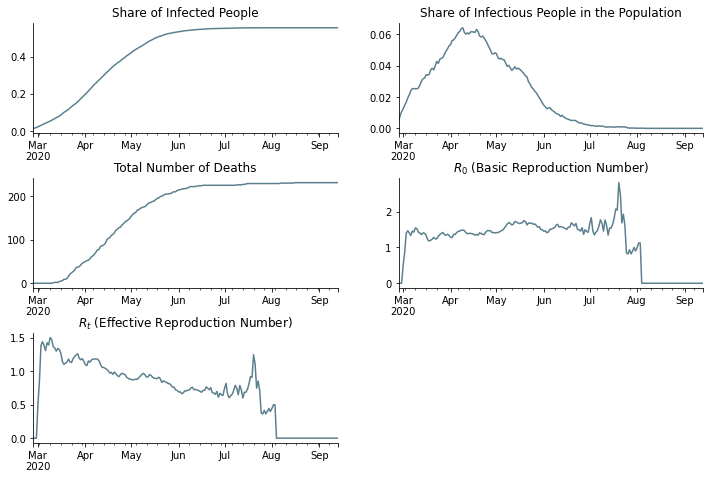

In [19]:
fig, axs = plt.subplots(3, 2, figsize=(12, 8))
fig.subplots_adjust(bottom=0.15, wspace=0.2, hspace=0.4)

axs = axs.flatten()

df.resample("D", on="date")["ever_infected"].mean().plot(ax=axs[0], color="#5c7f8e")
df.resample("D", on="date")["infectious"].mean().plot(ax=axs[1], color="#5c7f8e")
df.resample("D", on="date")["dead"].sum().plot(ax=axs[2], color="#5c7f8e")

r_zero = sid.statistics.calculate_r_zero(df, window_length=7)
r_zero.plot(ax=axs[3], color="#5c7f8e")

r_effective = sid.statistics.calculate_r_effective(df, window_length=7)
r_effective.plot(ax=axs[4], color="#5c7f8e")

for ax in axs:
    ax.set_xlabel("")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

axs[0].set_title("Share of Infected People")
axs[1].set_title("Share of Infectious People in the Population")
axs[2].set_title("Total Number of Deaths")
axs[3].set_title("$R_0$ (Basic Reproduction Number)")
axs[4].set_title("$R_t$ (Effective Reproduction Number)")

axs[5].set_visible(False)

plt.show()